# Geometry creation in pyGIMLi

Guide: https://github.com/halbmy/pyGIMLi-workshop/blob/main/1_basics/1_Creating_a_subsurface_model.ipynb

In [1]:
import pygimli as pg
from pygimli import meshtools as mt

A world is a layered subsurface.

Mesh: Nodes: 4 Cells: 0 Boundaries: 4


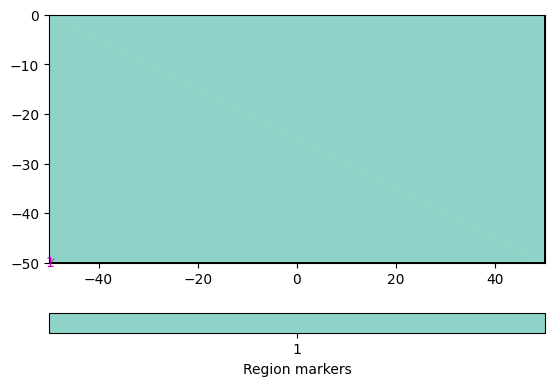

In [2]:
left  = -50
right = +50
depth = -50

layers = [-10]

world = mt.createWorld(
    start=[left, 0],
    end=[right, depth],
    # layers=layers,
    worldMarker=True
)

pg.show(world)
mt.exportPLC(world, "data/world.poly")
print(world)

## Polygons

Polygons are geological bodies.

You can create them by defining each of its vertices.

To improve precision, you can also define the number of nodes to interpolate between each vertex.

Make sure you set `isClosed=True` and `marker=<some-value>`.

In [52]:
def circle_factory(boundary_marker=None) -> pg.Mesh:
    circle = mt.createCircle(
        radius=4.0,
        nSegments=16,
        marker=2,
        isHole=False,
        boundaryMarker=boundary_marker or 2
    )
    circle.translate([-30, -20])
    return circle

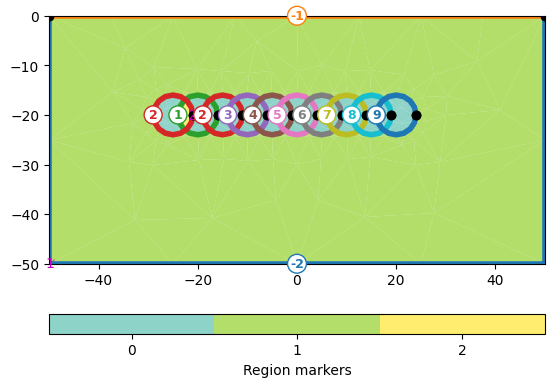

In [57]:
geometry = world
x = 5
circles = []

for i in range(10):
    circle = circle_factory(boundary_marker=i)
    circle.translate([x, 0])
    x += 5
    circles.append(circle)

worm = mt.mergeMeshes(circles)

geometry += worm

pg.show(geometry, boundaryMarkers=True, markers=True)
mt.exportPLC(geometry, "hole.poly")

## Creating a mesh for this geometry

Of course, to apply the finite element method, for our geometry, we need to first define a mesh.

pyGIMLi has different ways to create meshes. `mt.createMesh` creates a mesh using Triangle,
a two-dimensional constrained Delaunay mesh generator.


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fcc8197d410>)

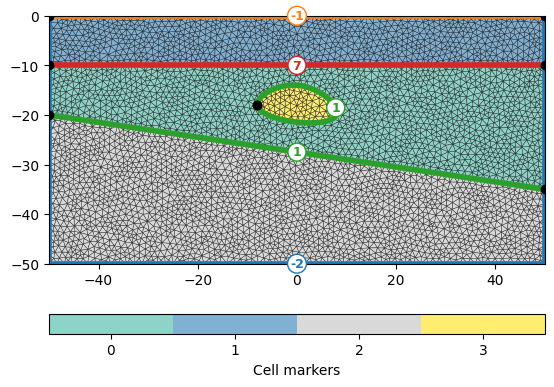

In [7]:
mesh = mt.createMesh(
    geometry,
    area=1.0,
    quality=30,
    smooth=[2, 4] # [0:no smoothing or 1:node center or 2:weighted node center, # of iter]
)

pg.show(mesh, markers=True, showMesh=True)

In [8]:
# Save geometry and mesh for later re-use

mt.exportPLC(geometry, "data/geometry.poly") # can be read by mt.readPLC()
mesh.save("data/mesh.bms") # can be load by pg.load()

1

In [9]:
# Just some plotting settings
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-notebook")

In [ ]:
import numpy as np

extruded_mesh = mt.extrudeMesh(mesh, np.linspace(0, 20, 5)) # adding dimension Z in this case
extruded_mesh.rotate([np.pi/2, 0, 0]) # rotating mesh to switch y/z direction and view the top of the extended mesh.

pg.show(extruded_mesh, extruded_mesh.cellMarkers(), showMesh=True); # pyvista powered (make sure to check Bane's tutorial tomorrow)s

Please note pyGIMLi is fully 3D-capable and that all the functions and methods we saw above are also working in 3D. Plus, you can read any externally created 3D mesh with mt.readMeshIO leveraging upon the wonderful meshio package.

Let's use this data for ERT modelling

R3Vector: n=40


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fcc52a54410>)

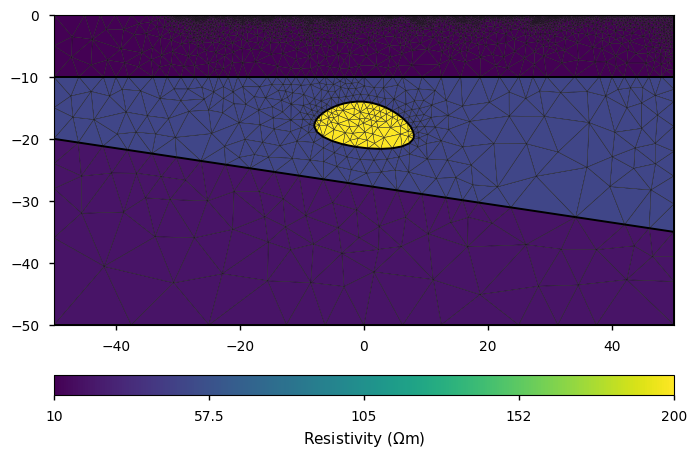

In [34]:
from pygimli.physics import ert


scheme = ert.createData(elecs=np.linspace(start=-30, stop=30, num=40), schemeName='dd')

print(scheme.sensors())

for p in scheme.sensors():
    geometry.createNode(p)
    geometry.createNode(p - [0, 0.2])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geometry, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [
    [0, 50.],
    [1, 10.],
    [2, 20. ],
    [3, 200. ],
]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

In [35]:
data = ert.simulate(
    mesh,
    scheme=scheme,
    res=rhomap,
    noiseLevel=1,
    noiseAbs=1e-6,
    seed=1337
)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

04/07/23 - 17:41:07 - pyGIMLi - INFO - Filtered rhoa (min/max) 9.492435938955529 26.350494310633845


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fcc53f65b10>)

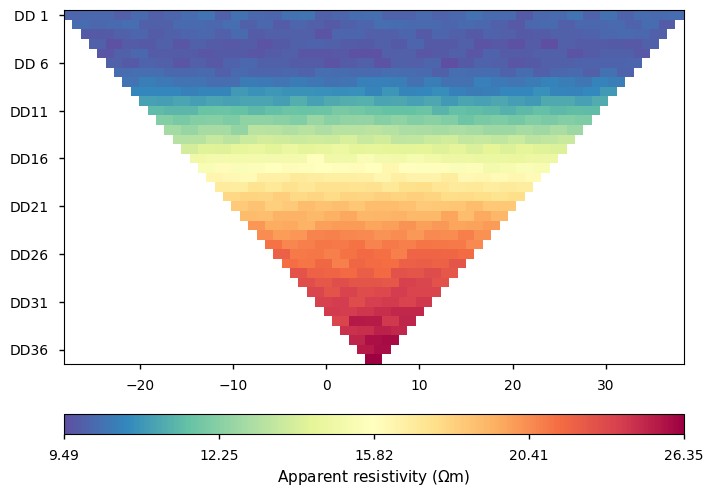

In [ ]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('data/simple.dat')

# You can take a look at the data
ert.show(data)

## Inversion with ERTManager

04/07/23 - 17:41:14 - pyGIMLi - INFO - Found 2 regions.
04/07/23 - 17:41:14 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
04/07/23 - 17:41:14 - pyGIMLi - INFO - Found 2 regions.
04/07/23 - 17:41:14 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
04/07/23 - 17:41:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
04/07/23 - 17:41:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
04/07/23 - 17:41:14 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1747 Cells: 3264 Boundaries: 2562
04/07/23 - 17:41:14 - pyGIMLi - INFO - Use median(data values)=11.8774866469241
04/07/23 - 17:41:14 - pyGIMLi - INFO - Created startmodel from forward operator: 610 [11.8774866469241,...,11.8774866469241]
04/07/23 - 17:41:14 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  0

Statistics:

  Input vertices: 87
  Input segments: 88
  Input holes: 0

  Mesh vertices: 466
  Mesh triangles: 816
  Mesh edges: 1281
  Mesh exterior boundary edges: 114
  Mesh interior boundary edges: 20
  Mesh subsegments (constrained edges): 134

min/max(dweight) = 45.366/99.9661
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7fcc65ad5d00>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7fcc6099b1f0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7fcc62cdb6f0>
min/max (d

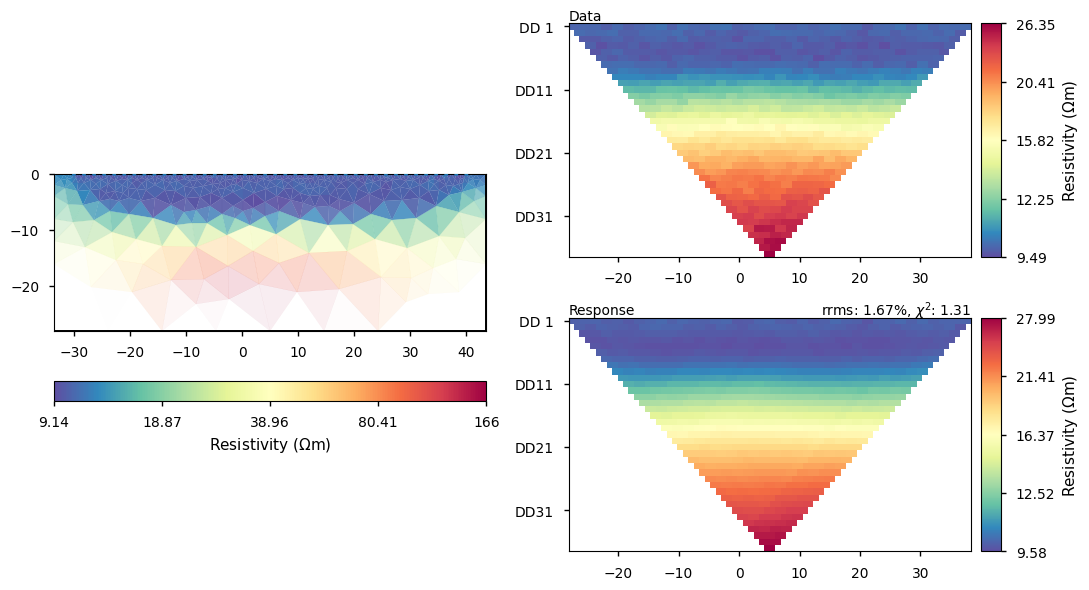

In [ ]:
mgr = ert.ERTManager('data/simple.dat')

inv = mgr.invert(lam=45, verbose=True)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

In [ ]:
# inversionDomain = pg.createGrid(x=np.linspace(start=-18, stop=18, num=33),
#                                 y=-pg.cat([0], pg.utils.grange(0.5, 8, n=5))[::-1],
#                                 marker=2)

# grid = pg.meshtools.appendTriangleBoundary(inversionDomain, marker=1,
#                                            xbound=50, ybound=50)
# pg.show(grid, markers=True)

# model = mgr.invert(data, mesh=grid, lam=20, verbose=True)
# # np.testing.assert_approx_equal(mgr.inv.chi2(), 1.4, significant=2)

# modelPD = mgr.paraModel(model)  # do the mapping
# pg.show(mgr.paraDomain, modelPD, label='Model', cMap='Spectral_r',
#         logScale=True, cMin=25, cMax=150)

# pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.fw.chi2()))

# fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,7))

# pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="Spectral_r", logScale=True,
#         orientation="vertical", cMin=25, cMax=150)
# pg.show(meshPD, inv, ax=ax2, hold=True, cMap="Spectral_r", logScale=True,
#         orientation="vertical", cMin=25, cMax=150)
# mgr.showResult(ax=ax3, cMin=25, cMax=150, orientation="vertical")

# labels = ["True model", "Inversion unstructured mesh", "Inversion regular grid"]
# for ax, label in zip([ax1, ax2, ax3], labels):
#     ax.set_xlim(mgr.paraDomain.xmin(), mgr.paraDomain.xmax())
#     ax.set_ylim(mgr.paraDomain.ymin(), mgr.paraDomain.ymax())
#     ax.set_title(label)